In [1]:
import torch
import torchvision
from torchvision.transforms import v2
import torchvision.models as models
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader

import os
import math
import random
import numpy as np
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import time
import wandb
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
from torch.utils.data import Dataset

class KidneyDataset(Dataset):
    def __init__(self, csv_dir, root_dir, transform=None):
        self.csv = pd.read_csv(csv_dir)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        row = self.csv.iloc[idx]
        img_path = self.root_dir / row['diag'] / (row['image_id'] + '.jpg')
        img = Image.open(img_path).convert('RGB')
        label = row['target']

        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [4]:
# Define color codes for terminal
class Colors:
    RESET = '\033[0m'
    GREEN = '\033[92m'
    RED = '\033[91m'
    YELLOW = '\033[93m'
    CYAN = '\033[96m'

def display_progress_bar(batch_idx, num_batches, loss, accuracy):
    """
    Function to display a colored progress bar.
    Args:
        batch_idx: Current batch index
        num_batches: Total number of batches
        loss: Current loss value
        accuracy: Current accuracy value
    """
    progress = (batch_idx + 1) / num_batches
    bar_length = 40  # Length of the progress bar (number of '==' chars)
    filled_length = int(bar_length * progress)
    bar = f"{Colors.GREEN}{'=' * filled_length}{Colors.RED}{'-' * (bar_length - filled_length)}{Colors.RESET}"

    print(f'\r[{bar}] {batch_idx + 1}/{num_batches} | {Colors.YELLOW}Loss:{Colors.RESET} {loss:.3f} | {Colors.YELLOW}Accuracy:{Colors.RESET} {accuracy:.2f}%', end='', flush=True)

In [5]:
import matplotlib.pyplot as plt

def plot_result(history, title="Training Progress"):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train', color='tomato')
    plt.plot(epochs, history['val_loss'], label='Validation', color='steelblue')
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(frameon=False)
    plt.grid(True, linestyle="--", alpha=0.3)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train', color='mediumseagreen')
    plt.plot(epochs, history['val_acc'], label='Validation', color='black')
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(frameon=False)
    plt.grid(True, linestyle="--", alpha=0.3)

    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [6]:
import copy


class EarlyStopping:
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.best_loss = float("inf")
        self.counter = 0
        self.best_model_state = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss - val_loss > self.delta:
            self.best_loss = val_loss
            self.best_model_state = self.best_model_state = copy.deepcopy(
                model.state_dict()
            )
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def load_best_model(self, model):
        if self.best_model_state is not None:
            model.load_state_dict(self.best_model_state)


In [7]:
import os
from typing import Optional, Any
from datetime import datetime
import time

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


class Trainer:
    def __init__(
        self,
        model: nn.Module,
        device: torch.device,
        optimizer: optim.Optimizer,
        criterion: nn.Module,
        scheduler: Optional[Any] = None,
    ):
        self.model = model.to(device)
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.history = {
            "train_loss": [],
            "train_acc": [],
            "val_loss": [],
            "val_acc": [],
        }

    def _run_epoch(self, loader, training=True, show_progress=True):
        self.model.train() if training else self.model.eval()

        running_loss = 0.0
        correct = 0
        total = 0
        all_preds, all_targets = [], []
        num_batches = len(loader)

        with torch.set_grad_enabled(training):
            for batch_idx, (inputs, targets) in enumerate(loader):
                inputs = inputs.to(self.device, non_blocking=True)
                targets = targets.to(self.device, non_blocking=True)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)

                if training:
                    loss.backward()
                    self.optimizer.step()
                    self.optimizer.zero_grad()

                running_loss += loss.item()
                _, preds = outputs.max(1)
                total += targets.size(0)
                correct += preds.eq(targets).sum().item()

                all_preds.extend(preds.cpu().tolist())
                all_targets.extend(targets.cpu().tolist())

                if show_progress:
                    current_loss = running_loss / (batch_idx + 1)
                    current_acc = 100.0 * correct / total

                    display_progress_bar(
                        batch_idx=batch_idx,
                        num_batches=num_batches,
                        loss=current_loss,
                        accuracy=current_acc,
                    )

        if show_progress:
            print()

        epoch_loss = running_loss / num_batches
        epoch_acc = 100.0 * accuracy_score(all_targets, all_preds)

        return epoch_loss, epoch_acc, all_preds, all_targets

    def fit(
        self,
        trainloader,
        valloader,
        epochs=10,
        patience=20,
        delta=1e-4,
        model_name="model",
        topk=5,
    ):
        best_vloss = float("inf")
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        start_time = time.time()
        early_stopping = EarlyStopping(patience=patience, delta=delta)
        topk_models = []

        for epoch in range(epochs):
            model_path = f"{model_name}_e{epoch}_{timestamp}.pt"

            print(f"\nEpoch {epoch + 1}/{epochs} - Training")
            t_loss, t_acc, _, _ = self._run_epoch(
                trainloader, training=True, show_progress=True
            )
            v_loss, v_acc, _, _ = self._run_epoch(
                valloader, training=False, show_progress=True
            )

            if self.scheduler:
                self.scheduler.step()

            # Log Metrics
            self.history["train_loss"].append(t_loss)
            self.history["train_acc"].append(t_acc)
            self.history["val_loss"].append(v_loss)
            self.history["val_acc"].append(v_acc)

            # Top K model saved
            if v_loss < best_vloss:
                best_vloss = v_loss
                best_model_weights = {
                    k: v.cpu().clone() for k, v in self.model.state_dict().items()
                }
                torch.save(best_model_weights, model_path)
                print(
                    f"\n--> NEW RECORD: Best model saved (Val loss: {best_vloss:.4f})"
                )
                topk_models.append((v_loss, model_path))
                topk_models.sort(key=lambda x: x[0])

                if topk_models is not None and len(topk_models) > topk:
                    _, worst_path = topk_models.pop(-1)
                    if os.path.exists(worst_path):
                        os.remove(worst_path)

            # Early Stopping
            early_stopping(val_loss=v_loss, model=self.model)

            if early_stopping.early_stop:
                print(
                    f"\nEarly stopping at epoch {epoch+1} with best validation loss: {early_stopping.best_loss:.4f}"
                )
                early_stopping.load_best_model(self.model)
                break

            print(f"\nTrain Loss: {t_loss:.4f}, Train Acc: {t_acc:.2f}%")
            print(f"Validation Loss: {v_loss:.4f}, Validation Acc: {v_acc:.2f}%")

        elapsed = time.time() - start_time
        print(f"\nTraining complete in {elapsed // 60:.0f}m {elapsed % 60:.0f}s")

        return self.history

    def evaluate(self, testloader, model_path=None):
        if model_path:
            self.model.load_state_dict(torch.load(model_path, map_location=self.device))

        loss, acc, preds, targets = self._run_epoch(
            testloader, training=False, show_progress=True
        )

        metrics = {
            "loss": loss,
            "accuracy": acc / 100,
            "precision": precision_score(
                targets, preds, average="weighted", zero_division=0
            ),
            "f1": f1_score(targets, preds, average="weighted", zero_division=0),
        }

        print("\n" + "=" * 25 + "\nTEST SET RESULTS\n" + "=" * 25)

        for k, v in metrics.items():
            print(f"{k.capitalize():<10}: {v:.4f}")

        return preds, targets, metrics


In [8]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

## Training

In [9]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

classes = 4
input_dim = 224
lr = 3e-4
weight_decay=0.05
epochs = 100
warmup_epochs=10
batch_size = 64
max_models=5
patience=10
delta=1e-3

csv_dir = '/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/kidneyData.csv'
root_dir = Path('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone')

train_transform = v2.Compose([
    v2.Resize((input_dim, input_dim)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=5),
    v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2337, 0.2337, 0.2337]),
])

val_transform = v2.Compose([
    v2.Resize((input_dim, input_dim)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2337, 0.2337, 0.2337]),
])

temp_dataset = KidneyDataset(csv_dir, root_dir, transform=None)
dataset_size = len(temp_dataset)
indices = list(range(dataset_size))
all_labels = temp_dataset.csv['Class']

train_indices, temp_indices = train_test_split(
    indices, 
    test_size=0.30, 
    stratify=all_labels,
    random_state=42, 
    shuffle=True
)


temp_labels = [all_labels[i] for i in temp_indices]

val_indices, test_indices = train_test_split(
    temp_indices, 
    test_size=0.5, 
    stratify=temp_labels,
    random_state=42, 
    shuffle=True
)


train_base = KidneyDataset(csv_dir, root_dir, transform=train_transform)
val_base = KidneyDataset(csv_dir, root_dir, transform=val_transform)
test_base = KidneyDataset(csv_dir, root_dir, transform=val_transform)

train_dataset = Subset(train_base, train_indices)
val_dataset = Subset(val_base, val_indices)
test_dataset = Subset(test_base, test_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training set: {len(train_dataset)}")
print(f"Val set: {len(val_dataset)}")
print(f"Test set: {len(test_dataset)}")

Training set: 8712
Val set: 1867
Test set: 1867


In [10]:
from torchvision.models import swin_t

model = swin_t(
    weights=None,
    num_classes=classes
)

# Count parameters
total_params, trainable_params = count_parameters(model)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

# Define loss and optimizer
class_weights = torch.tensor([0.613, 0.839, 1.364, 2.26], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

warmup_scheduler = optim.lr_scheduler.LinearLR(
    optimizer,
    start_factor=1e-3,
    total_iters=warmup_epochs
)
cosine_scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=epochs - warmup_epochs
    
)

scheduler = optim.lr_scheduler.SequentialLR(
    optimizer,
    schedulers=[warmup_scheduler, cosine_scheduler],
    milestones=[warmup_epochs]
)

Total parameters: 27522430
Trainable parameters: 27522430


In [11]:
trainer = Trainer(
    model=model,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler
)

In [12]:
result = trainer.fit(
    trainloader=train_loader,
    valloader=val_loader,
    epochs=epochs,
    model_name="swin_t_exp3",
    patience=patience,
    delta=delta
)


Epoch 1/100 - Training
[========================================] 137/137 | Loss: 1.330 | Accuracy: 24.46%
[========================================] 30/30 | Loss: 1.288 | Accuracy: 24.37%

--> NEW RECORD: Best model saved (Val loss: 1.2879)

Train Loss: 1.3296, Train Acc: 24.46%
Validation Loss: 1.2879, Validation Acc: 24.37%

Epoch 2/100 - Training
[========================================] 137/137 | Loss: 1.110 | Accuracy: 52.22%
[========================================] 30/30 | Loss: 1.023 | Accuracy: 66.90%

--> NEW RECORD: Best model saved (Val loss: 1.0227)

Train Loss: 1.1103, Train Acc: 52.22%
Validation Loss: 1.0227, Validation Acc: 66.90%

Epoch 3/100 - Training
[========================================] 137/137 | Loss: 1.028 | Accuracy: 57.59%
[========================================] 30/30 | Loss: 0.961 | Accuracy: 69.47%

--> NEW RECORD: Best model saved (Val loss: 0.9611)

Train Loss: 1.0276, Train Acc: 57.59%
Validation Loss: 0.9611, Validation Acc: 69.47%

Epoch 4/1

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[========================================] 137/137 | Loss: 0.575 | Accuracy: 76.62%
[========================================] 30/30 | Loss: 0.448 | Accuracy: 80.56%

--> NEW RECORD: Best model saved (Val loss: 0.4482)

Train Loss: 0.5753, Train Acc: 76.62%
Validation Loss: 0.4482, Validation Acc: 80.56%

Epoch 12/100 - Training
[========================================] 137/137 | Loss: 0.472 | Accuracy: 80.70%
[========================================] 30/30 | Loss: 0.371 | Accuracy: 85.75%

--> NEW RECORD: Best model saved (Val loss: 0.3710)

Train Loss: 0.4722, Train Acc: 80.70%
Validation Loss: 0.3710, Validation Acc: 85.75%

Epoch 13/100 - Training
[========================================] 137/137 | Loss: 0.493 | Accuracy: 80.38%
[========================================] 30/30 | Loss: 0.397 | Accuracy: 85.38%

Train Loss: 0.4934, Train Acc: 80.38%
Validation Loss: 0.3970, Validation Acc: 85.38%

Epoch 14/100 - Training
[========================================] 137/137 | Loss: 0

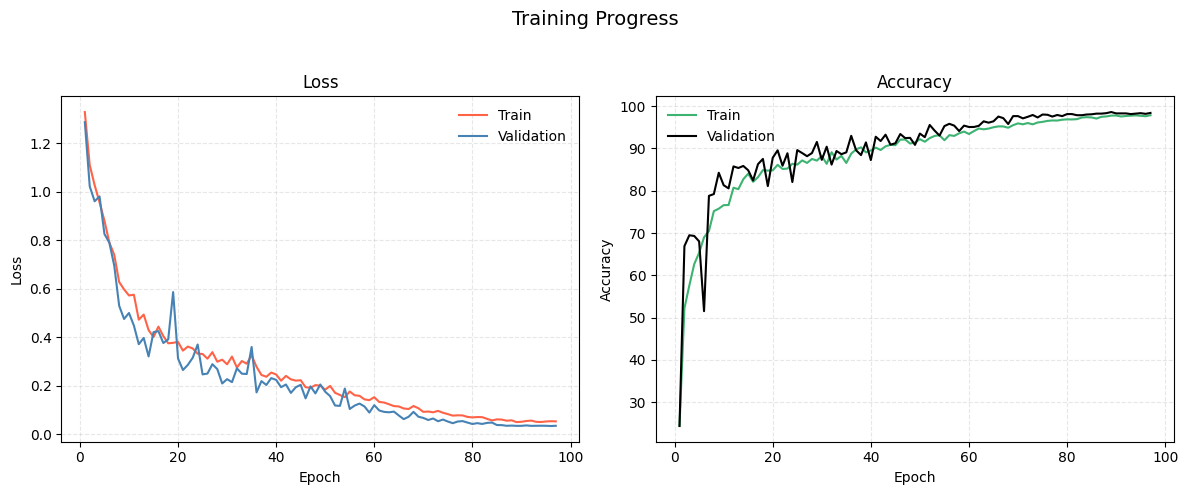

In [15]:
plot_result(result)

In [16]:
results = trainer.evaluate(
    testloader=test_loader,
    model_path="/kaggle/working/swin_t_exp3_e95_20260210_112621.pt"
)

[========================================] 30/30 | Loss: 0.040 | Accuracy: 98.18%

TEST SET RESULTS
Loss      : 0.0404
Accuracy  : 0.9818
Precision : 0.9818
F1        : 0.9818


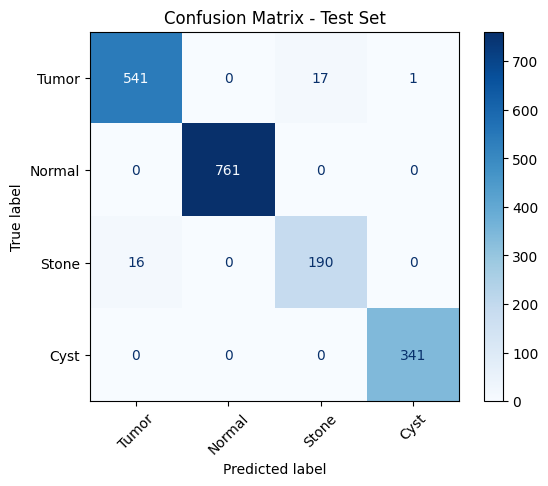

In [17]:
cm = confusion_matrix(results[0], results[1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Tumor', 'Normal', 'Stone', 'Cyst'])
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Test Set")
plt.show()